# Hands-on Day 2

## You'll learn

### ML methods
- Gradient Boosting Trees with pyspark.ml

### ML techniques
- hyperparameter optimisation
- ROC curves

In [41]:
#initial imports
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

# initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
num_workers=10
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-marchisi01>

# Data preprocessing

In [43]:
# inputFile = 'file:///home/jovyan/Higgs100k.parquet'
inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

CPU times: user 922 µs, sys: 1.3 ms, total: 2.22 ms
Wall time: 1.01 s
There are 999999 events


##  Exercise 1

- split the dataframe *df* into two dataframes, called *train* and *test* containing respectively 80% and 20% of the events (randomly distributed between the two samples) 

In [61]:
#split the dataset for training and test

train, test = df.randomSplit([0.8, 0.2], seed=42)

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Events for training 799791
Events for validation 200208


#### Create the input feature vector - remember, this was part of yesterday hands-on (bonus)

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe *train* a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer
- do the same for dataframe *test*

In [62]:
feature = df.columns
feature.remove('label')
print('Features used for training: {}'.format(feature))

Features used for training: ['lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_b-tag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_b-tag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_b-tag', 'jet4_pt', 'je4_eta', 'jet4_phi', 'jet4_b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [63]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature, outputCol='features')

train = assembler.transform(train)
test  = assembler.transform(test)

# ML models: GBT

In [65]:
# ML model: GBT (Gradient Boosting Trees)
# Documentation at https://spark.apache.org/docs/2.2.0/ml-classification-regression.html
from pyspark.ml.classification import GBTClassifier

# fast, about 1m to train
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10, maxDepth=3) 

In [66]:
%%time
gbt_model = gbt.fit(train)

CPU times: user 13.4 ms, sys: 5.77 ms, total: 19.2 ms
Wall time: 15.3 s


In [78]:
# compute AUC on the test set
result = gbt_model.transform(test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.7426207859552686


In [79]:
#print metrics
printMetrics(evaluator, result)

AUC: 0.743
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|75437|
|  0.0|       1.0|34428|
|  1.0|       0.0|30883|
|  0.0|       0.0|59460|
+-----+----------+-----+

n precision: 0.687
n recall: 0.710
n accuracy: 0.674
n F1 score: 0.698


In [80]:
gbt_model.extractParamMap()

{Param(parent='GBTClassifier_7dd44a49585e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_7dd44a49585e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_7dd44a49585e', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

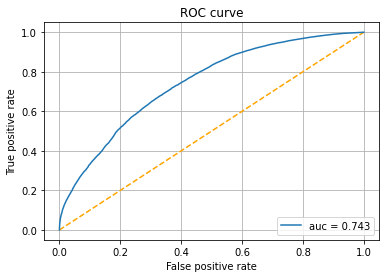

In [81]:
#make ROC curve
drawROC(result)

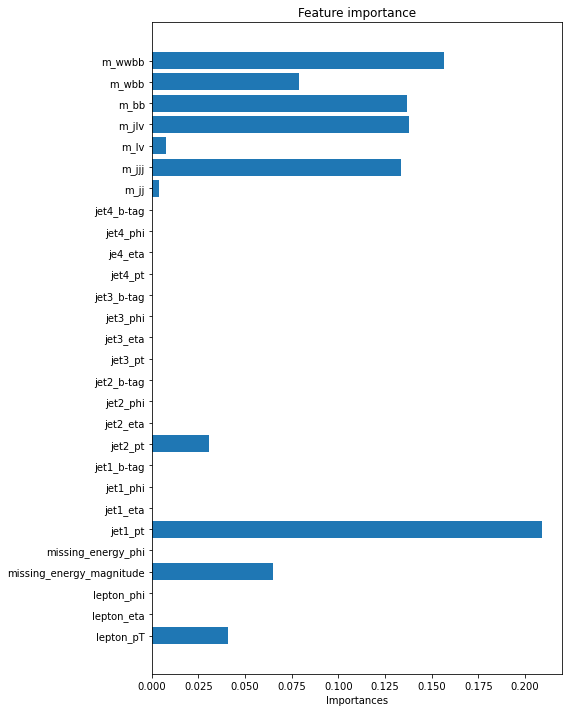

In [82]:
#plot features vs importance
drawFeatures(feature, gbt_model)

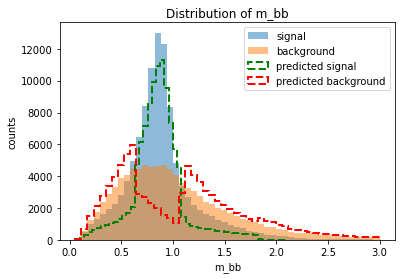

In [83]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

## Exercise 2

- try to change the hyperparameters of the GBT model (maxIter=50, maxDepth=10), and check what changes in terms of performances, feature importance, signal versus background separation. Be careful of training time if you increase them too much!

In [86]:
gbt_2 = GBTClassifier(labelCol='label', featuresCol='features', maxIter=50, maxDepth=10) 

In [87]:
%%time
gbt_model_2 = gbt_2.fit(train)

CPU times: user 41.1 ms, sys: 18.3 ms, total: 59.5 ms
Wall time: 5min 54s


In [88]:
# compute AUC on the test set
result_2 = gbt_model_2.transform(test)

# evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result_2)))

Test set AUC = 0.8137626306477165


In [89]:
#print metrics
printMetrics(evaluator, result_2)

AUC: 0.814
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|80247|
|  0.0|       1.0|27290|
|  1.0|       0.0|26073|
|  0.0|       0.0|66598|
+-----+----------+-----+

n precision: 0.746
n recall: 0.755
n accuracy: 0.733
n F1 score: 0.750


In [90]:
# gbt_model_2.extractParamMap()

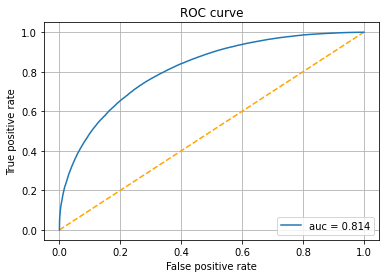

In [93]:
#make ROC curve
drawROC(result_2)

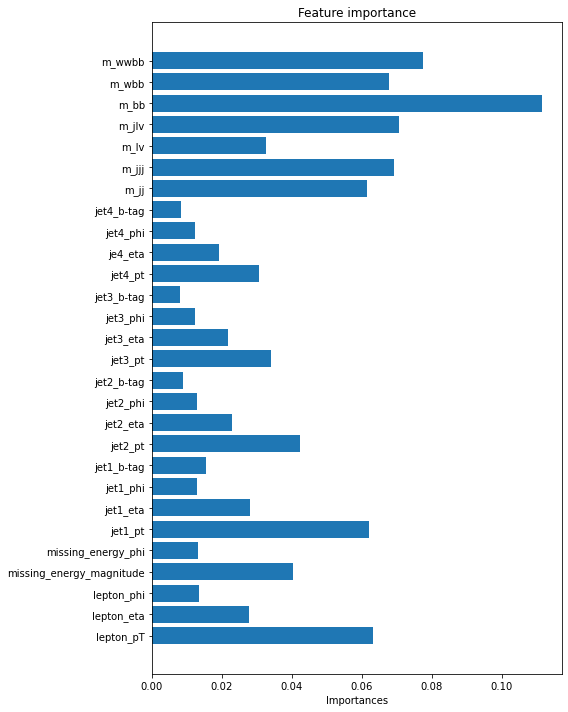

In [91]:
#plot features vs importance
drawFeatures(feature, gbt_model_2)

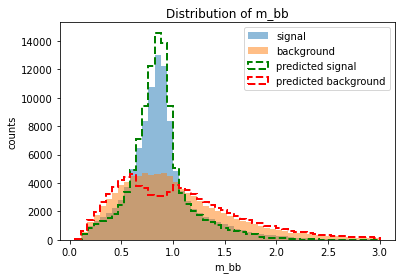

In [92]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result_2, 'm_bb')

# Hyperparameter scan

- documentation: https://spark.apache.org/docs/latest/ml-tuning.html

In [94]:
#reduce number of events for training if needed
subSample = train.sample(fraction=1.0/10, withReplacement=False).cache()
print('We will use ' +str(subSample.count()) + ' events for the grid search')

We will use 79660 events for the grid search


In [95]:
#Do hyperparameter tuning 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10, maxDepth=3)

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

#choose hyperparameter space
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [1,5])\
  .addGrid(gbt.maxIter, [10,20])\
  .build()

In [96]:
# Train Validation Split (takes 1-2 minutes)
tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)# 80% of the data will be used for training, 20% for validation

**TIP:** after starting the following cell, close the Spark monitoring window or it will slow down your notebook display considerably.

In [97]:
#take care, might take long time, 
%time bestModel = tvs.fit(subSample)

CPU times: user 157 ms, sys: 67.9 ms, total: 225 ms
Wall time: 51.9 s


In [98]:
#It is possile to see the score obtained (in this case the AUC) for each set of parameters
#zip(bestModel.avgMetrics, paramGrid)

print('maxDepth = '+str(bestModel.bestModel._java_obj.getMaxDepth()))
print('maxIter = '+str(bestModel.bestModel._java_obj.getMaxIter()))

maxDepth = 5
maxIter = 20


In [99]:
# compute accuracy on the test set
result = bestModel.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.779074347381322


In [ ]:
#make ROC curve with best model
drawROC(result)

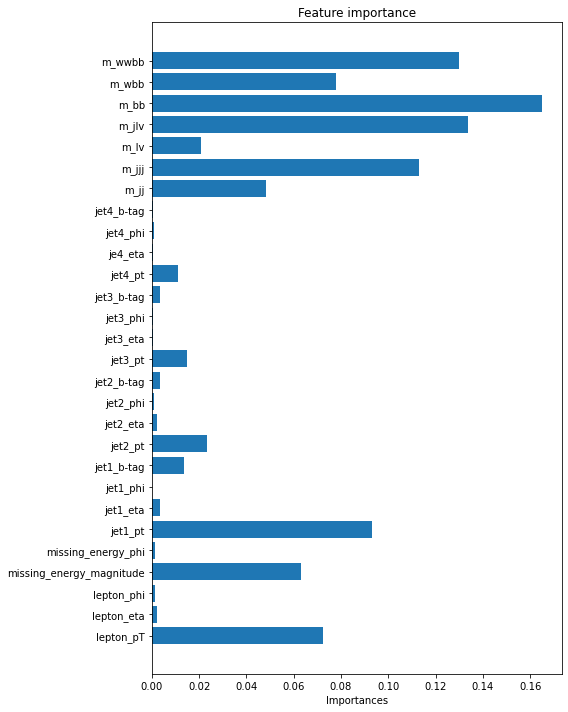

In [101]:
# plot features vs importance
drawFeatures(feature, bestModel.bestModel)

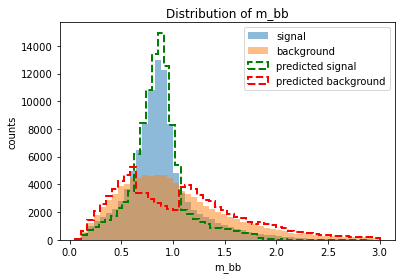

In [102]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

## Exercise 3

- try implementing the cross validation method, and describe what changes (results, training time, performances, ...): do you get the same hyper-parameters?

In [104]:
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10, maxDepth=3)

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

#choose hyperparameter space
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [1,5])\
  .addGrid(gbt.maxIter, [10,20])\
  .build()

In [105]:
cv = CrossValidator(estimator=gbt, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=10,
                    parallelism=num_workers
                    )

In [107]:
%%time
bestModel = cv.fit(subSample)

CPU times: user 1.82 s, sys: 792 ms, total: 2.61 s
Wall time: 3min 45s


In [ ]:
#It is possile to see the score obtained (in this case the AUC) for each set of parameters
#zip(bestModel.avgMetrics, paramGrid)

for params, metric in zip(paramGrid, bestModel.avgMetrics):
    print(f"Params: {params} => AUC: {metric}")

Params: {Param(parent='GBTClassifier_cd02562a22f2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 1, Param(parent='GBTClassifier_cd02562a22f2', name='maxIter', doc='max number of iterations (>= 0).'): 10} => AUC: 0.7013439779764195
Params: {Param(parent='GBTClassifier_cd02562a22f2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 1, Param(parent='GBTClassifier_cd02562a22f2', name='maxIter', doc='max number of iterations (>= 0).'): 20} => AUC: 0.712987820947014
Params: {Param(parent='GBTClassifier_cd02562a22f2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_cd02562a22f2', name='maxIter', doc='max number of iterations (>= 0).'): 10} => AUC: 0.7629412318739025
Params: {Param(parent='GBTCla

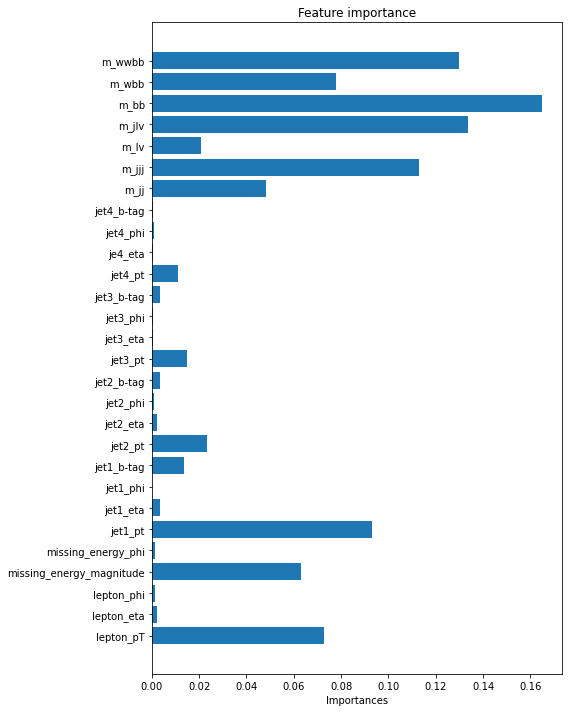

In [109]:
# plot features vs importance
drawFeatures(feature, bestModel.bestModel)

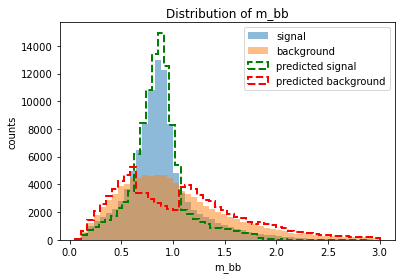

In [110]:
# plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

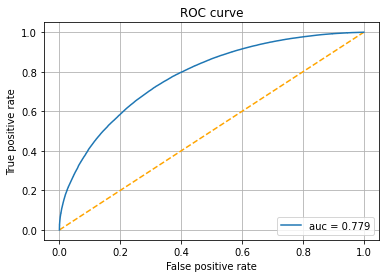

In [112]:
# make ROC curve
drawROC(result)

In [114]:
#when you're done, stop spark, this will release the resources you're using
spark.stop()

In [115]:
!kubectl get pods

No resources found in marchisi01 namespace.
